## Preparação e Limpeza de Dados

In [26]:
# Importação das Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Treinamento Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

In [27]:
# Carregamento e leitura das bibliotecas
df = pd.read_csv("docs/treino.csv")

df.head()


,op_padronizado,dt_ocorrencia,hr_ocorrencia,uf,regiao,latitude,longitude,cat_aeronave,fase_operacao,modelo_aeronave,peso_max_decolagem,numero_assentos,nome_fabricante,les_fatais_trip
0,AEROAGRICOLA CHAPADAO LTDA,21/12/1999,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-235,1315.0,1.0,PIPER AIRCRAFT,0
1,RONDON AVIACAO AGRICOLA LTDA,06/01/2000,NaN,MT,Centro-Oeste,NaN,NaN,S05,NaN,EMB-201,1800.0,1.0,NEIVA,0
2,SAPA SERV. AEREO DE PROTECAO AGRICOLA,22/02/2000,NaN,RS,Sul,NaN,NaN,S05,NaN,A188B,1497.0,1.0,CESSNA AIRCRAFT,0
3,AERO AGRICOLA CAICARA LTDA,10/05/2000,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-260,1315.0,1.0,PIPER AIRCRAFT,0
4,AVIACAO AGRICOLA RECREIO LTDA,09/11/2000,NaN,Indeterminado,NaN,NaN,NaN,TPP,NaN,369HS,1157.0,5.0,HUGHES HELICOPTER,0


 Tratamento de dados

In [28]:
# Pegar informações da Tabela
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


In [29]:
# Remoção de duplicatas

print("--- Informações Iniciais do DataFrame ---")
df.info()

# Verifica e remove linhas duplicadas
linhas_antes = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Linhas antes da remoção de duplicatas: {linhas_antes}")
print(f"Linhas após a remoção de duplicatas: {len(df)}")

--- Informações Iniciais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB
Linha

In [30]:
# Converte latitude e longitude para números, trocando a vírgula por ponto
print("Convertendo 'latitude' e 'longitude' para Float")
df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)

# Converte a coluna de data para o formato datetime
# O interpretado não consegue entender o formato Object para data e hora
print("Convertendo 'dt_ocorrencia' para formato de data...")
df['dt_ocorrencia'] = pd.to_datetime(df['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')

# Verifica o tipo de dados após a conversão
df.info()

Convertendo 'latitude' e 'longitude' para Float
Convertendo 'dt_ocorrencia' para formato de data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   op_padronizado      508 non-null    object        
 1   dt_ocorrencia       510 non-null    datetime64[ns]
 2   hr_ocorrencia       340 non-null    object        
 3   uf                  510 non-null    object        
 4   regiao              447 non-null    object        
 5   latitude            358 non-null    float64       
 6   longitude           358 non-null    float64       
 7   cat_aeronave        510 non-null    object        
 8   fase_operacao       367 non-null    object        
 9   modelo_aeronave     507 non-null    object        
 10  peso_max_decolagem  508 non-null    float64       
 11  numero_assentos     508 non-null    float64       
 12  nome_f

In [31]:
# Comando para verificar se há valores nulos na tabela
print(df.isnull().sum())


op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
dtype: int64


In [32]:
# Tratamento dos valores (NaN)

print("\n--- Contagem de valores nulos ANTES do tratamento ---")


# Lista de colunas numéricas para imputar com a mediana
colunas_numericas_nan = ['peso_max_decolagem', 'numero_assentos']
for col in colunas_numericas_nan:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)
    print(f"Valores nulos em '{col}' preenchidos com a mediana: {mediana}")

print("-" * 20)

# Lista de colunas categóricas para imputar com a moda
colunas_categoricas_nan = ['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']
for col in colunas_categoricas_nan:
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda)
    print(f"Valores nulos em '{col}' preenchidos com a moda: '{moda}'")

print("-" * 20)

# Removendo linhas onde dados essenciais ainda são nulos
print("Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...")
df.dropna(subset=['dt_ocorrencia', 'latitude', 'longitude'], inplace=True)

print("\n--- Contagem de valores nulos DEPOIS do tratamento ---")
print(df.isnull().sum())


--- Contagem de valores nulos ANTES do tratamento ---
Valores nulos em 'peso_max_decolagem' preenchidos com a mediana: 1800.0
Valores nulos em 'numero_assentos' preenchidos com a mediana: 1.0
--------------------
Valores nulos em 'op_padronizado' preenchidos com a moda: 'AERO AGRICOLA CAICARA LTDA'
Valores nulos em 'hr_ocorrencia' preenchidos com a moda: '10:30:00'
Valores nulos em 'regiao' preenchidos com a moda: 'Sul'
Valores nulos em 'fase_operacao' preenchidos com a moda: 'Especializada'
Valores nulos em 'modelo_aeronave' preenchidos com a moda: 'EMB-202'
Valores nulos em 'nome_fabricante' preenchidos com a moda: 'NEIVA'
--------------------
Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...

--- Contagem de valores nulos DEPOIS do tratamento ---
op_padronizado        0
dt_ocorrencia         0
hr_ocorrencia         0
uf                    0
regiao                0
latitude              0
longitude             0
cat_aeronave          0
fase_operacao      

In [33]:
# Bloco de criação de novas colunas

print("\nCriando colunas 'ano_ocorrencia' e 'mes_ocorrencia' a partir da data...")

df['ano_ocorrencia'] = df['dt_ocorrencia'].dt.year
df['mes_ocorrencia'] = df['dt_ocorrencia'].dt.month

# Novas colunas criadas
print("\n--- Visualizando as novas colunas ---")
display(df[['dt_ocorrencia', 'ano_ocorrencia', 'mes_ocorrencia']].head())


Criando colunas 'ano_ocorrencia' e 'mes_ocorrencia' a partir da data...

--- Visualizando as novas colunas ---


,dt_ocorrencia,ano_ocorrencia,mes_ocorrencia
63,2008-03-23,2008,3
66,2008-04-02,2008,4
103,2010-04-15,2010,4
110,2010-11-16,2010,11
120,2011-01-06,2011,1


## Preparação para a Modelagem

--- Verificando o Balanceamento da Variável Alvo (y) ---
les_fatais_trip
0    307
1     51
Name: count, dtype: int64


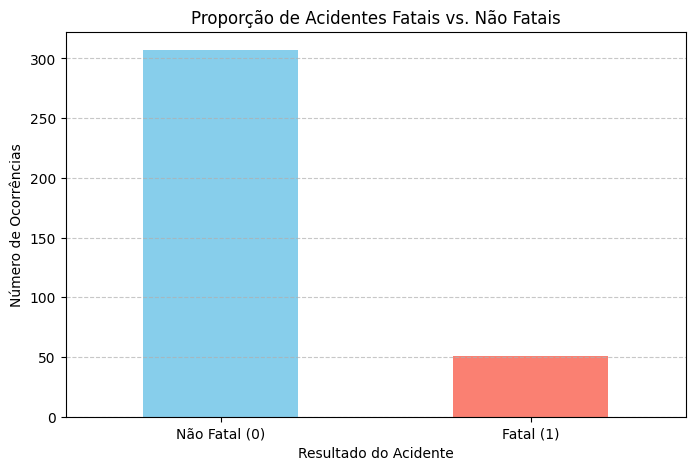


Como o gráfico mostra, a barra de 'Não Fatal' é muito mais alta que a de 'Fatal'.
Isso é a definição de um 'dataset desbalanceado'.


In [34]:
## Pela análise do CSV, a coluna les_fatais_trip parece ser a melhor coluna, ela distingue se os acidentes foram fatais ou não

# Então o X vai ser todas as colunas que queremos comparar com o Y
# Sendo Y o les_fatais_trip

# Essas colunas vão ser as colunas que vamos querer comparar com o les_fatais_trip


# --- Seleção de Features (X) e Alvo (y) ---
# (A seleção continua a mesma)
features_selecionadas = [
    'latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
    'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
    'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia'
]
X = df[features_selecionadas]
y = df['les_fatais_trip']

# --- Visualização do Balanceamento ---
print("--- Verificando o Balanceamento da Variável Alvo (y) ---")

# Contando os valores
contagem_classes = y.value_counts()
print(contagem_classes)

# Criando o gráfico de barras
plt.figure(figsize=(8, 5)) # Define o tamanho da figura
contagem_classes.plot(kind='bar', color=['skyblue', 'salmon'])

# Adicionando títulos e rótulos para ficar mais claro
plt.title('Proporção de Acidentes Fatais vs. Não Fatais')
plt.xlabel('Resultado do Acidente')
plt.ylabel('Número de Ocorrências')
plt.xticks([0, 1], ['Não Fatal (0)', 'Fatal (1)'], rotation=0) # Renomeia os eixos 0 e 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibe o gráfico
plt.show()

print("\nComo o gráfico mostra, a barra de 'Não Fatal' é muito mais alta que a de 'Fatal'.")
print("Isso é a definição de um 'dataset desbalanceado'.")

In [35]:


# Dividindo os dados: 70% para treino e 30% para teste.
# test_size=0.3: Define que 30% dos dados serão para o conjunto de teste.
# random_state=42: Garante que a divisão seja sempre a mesma, tornando nosso resultado reproduzível.
# stratify=y: MUITO IMPORTANTE! Garante que a proporção de 0s e 1s seja a mesma tanto no treino quanto no teste.
#              Isso é essencial para datasets desbalanceados como o nosso..

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Verificando os tamanhos dos conjuntos criados
print(f"Tamanho do conjunto de Treino (X_train): {len(X_train)} linhas")
print(f"Tamanho do conjunto de Teste (X_test):   {len(X_test)} linhas")

Tamanho do conjunto de Treino (X_train): 250 linhas
Tamanho do conjunto de Teste (X_test):   108 linhas


## Treinar o modelo

In [36]:
# Bloco 8: Definição do Pipeline de Pré-processamento

# 1. Identificar novamente as colunas numéricas e categóricas que estamos usando
#    Isso ajuda a manter o código claro e organizado
colunas_numericas = X_train.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("Colunas Numéricas para Padronização:")
print(colunas_numericas)
print("\nColunas Categóricas para One-Hot Encoding:")
print(colunas_categoricas)

# 2. Criar o pré-processador (o "gerente" das transformações)
#    Esta estrutura é baseada no notebook do professor.ipynb, regressao_logistica_binaria_simple[code_along].ipynb]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas)
    ],
    remainder='passthrough' # Mantém colunas não especificadas, se houver
)

Colunas Numéricas para Padronização:
['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia']

Colunas Categóricas para One-Hot Encoding:
['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']


In [37]:
# Bloco 9: Criação e Treinamento dos Pipelines dos Modelos



# --- Criação dos Pipelines ---
# Cada pipeline conecta o pré-processador a um classificador diferente

# Pipeline 1: Modelo Baseline (Dummy)
pipeline_dummy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))
])

# Pipeline 2: Regressão Logística
pipeline_logistica = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Pipeline 3: Árvore de Decisão
pipeline_arvore = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])


# --- Treinamento dos Modelos ---
# Usamos o método .fit() com os dados de TREINO (X_train, y_train)

print("Treinando o modelo Baseline (Dummy)...")
pipeline_dummy.fit(X_train, y_train)
print("Treinamento concluído.")

print("\nTreinando o modelo de Regressão Logística...")
pipeline_logistica.fit(X_train, y_train)
print("Treinamento concluído.")

print("\nTreinando o modelo de Árvore de Decisão...")
pipeline_arvore.fit(X_train, y_train)
print("Treinamento concluído.")

Treinando o modelo Baseline (Dummy)...
Treinamento concluído.

Treinando o modelo de Regressão Logística...
Treinamento concluído.

Treinando o modelo de Árvore de Decisão...
Treinamento concluído.


## Avaliação e Análise

,Modelo,Acurácia,Precisão,Recall,F1-Score
0,Baseline (Dummy),0.861111,0.000000,0.000000,0.000000
1,Regressão Logística,0.750000,0.285714,0.533333,0.372093
2,Árvore de Decisão,0.796296,0.294118,0.333333,0.312500



--- Matriz de Confusão: Regressão Logística ---


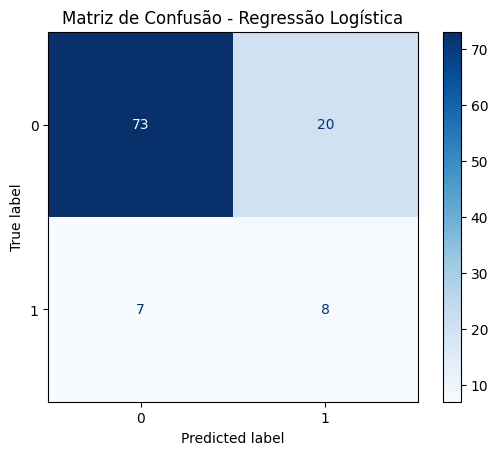


--- Matriz de Confusão: Árvore de Decisão ---


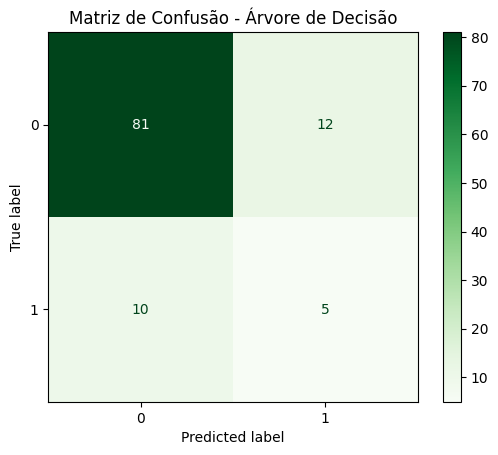

In [38]:
# Bloco 10: Avaliação dos Modelos com Métricas de Classificação

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- 1. Fazendo as previsões no conjunto de TESTE ---
y_pred_dummy = pipeline_dummy.predict(X_test)
y_pred_logistica = pipeline_logistica.predict(X_test)
y_pred_arvore = pipeline_arvore.predict(X_test)

# --- 2. Criando um DataFrame para comparar as métricas ---
# Esta abordagem é similar à do notebook do professor.ipynb]

metricas = {
    'Modelo': ['Baseline (Dummy)', 'Regressão Logística', 'Árvore de Decisão'],
    'Acurácia': [accuracy_score(y_test, y_pred_dummy), 
                 accuracy_score(y_test, y_pred_logistica), 
                 accuracy_score(y_test, y_pred_arvore)],
    'Precisão': [precision_score(y_test, y_pred_dummy, zero_division=0), 
                 precision_score(y_test, y_pred_logistica, zero_division=0), 
                 precision_score(y_test, y_pred_arvore, zero_division=0)],
    'Recall': [recall_score(y_test, y_pred_dummy, zero_division=0), 
               recall_score(y_test, y_pred_logistica, zero_division=0), 
               recall_score(y_test, y_pred_arvore, zero_division=0)],
    'F1-Score': [f1_score(y_test, y_pred_dummy, zero_division=0), 
                 f1_score(y_test, y_pred_logistica, zero_division=0), 
                 f1_score(y_test, y_pred_arvore, zero_division=0)]
}

df_metricas = pd.DataFrame(metricas)
display(df_metricas)


# --- 3. Visualizando a Matriz de Confusão ---
# A matriz de confusão nos ajuda a ver os tipos de erros e acertos. [cite: 18]

print("\n--- Matriz de Confusão: Regressão Logística ---")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logistica, cmap='Blues')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

print("\n--- Matriz de Confusão: Árvore de Decisão ---")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_arvore, cmap='Greens')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()

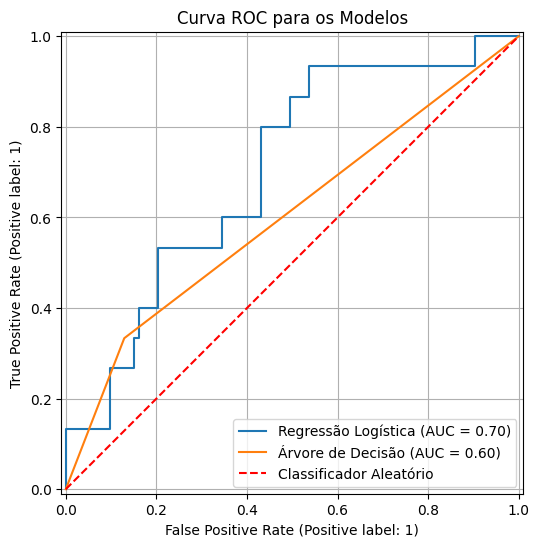

In [39]:
# Bloco 11: Análise da Curva ROC e AUC

from sklearn.metrics import RocCurveDisplay

# Criando a visualização
fig, ax = plt.subplots(figsize=(8, 6))

# Plotando a curva para a Regressão Logística
RocCurveDisplay.from_estimator(pipeline_logistica, X_test, y_test, name='Regressão Logística', ax=ax)

# Plotando a curva para a Árvore de Decisão
RocCurveDisplay.from_estimator(pipeline_arvore, X_test, y_test, name='Árvore de Decisão', ax=ax)

# Adicionando a linha de referência do "chute aleatório"
ax.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classificador Aleatório')

plt.title('Curva ROC para os Modelos')
plt.legend()
plt.grid()
plt.show()